# Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

### Инструкция по выполнению проекта

    1. Загрузите данные и выполните их ресемплирование по одному часу.
    2. Проанализируйте данные.
    3. Обучите разные модели с различными гиперпараметрами. Сделайте тестовую выборку размером 10% от исходных данных.
    4. Проверьте данные на тестовой выборке и сделайте выводы.

### Описание данных

Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце '*num_orders*' (от англ. *number of orders*, «число заказов»).
___
<a id="start"></a>
# Содержание



## Подготовка данных
   * <a href='#step_1'> Загружаем библиотеки </a>
   * <a href='#step_1.1'> Откроем файл и изучим его </a>
          - Путь к файлу: (/datasets/taxi.csv)
   * <a href='#step_1.2'>Посмотрим на распределение данных в таблице</a>
   * <a href='#step_1.3'>Выполним ресемплирование наших данных по одному часу</a>
   * <a href='#step_1.4'>Приведём в целочисленный формат количество заказов</a>
   * <a href='#step_1.end'> Вывод </a>

## Анализ
   * <a href='#step_2'> Построим график распределения количества заказов в час за весь период </a>
   * <a href='#step_2.1'> Определим тренд </a>
   * <a href='#step_2.2'> Определим сезонность</a>
   * <a href='#step_2.3'>Остаток декомпозиции</a>
   * <a href='#step_2.4'> Для более качествоенного предсказания моделей оценим распределение даных и отсортируем (шумные)выбивающиеся значения </a>
  
   * <a href='#step_2.end'> Вывод </a>   
      
## Обучение
   * <a href='#step_3'> Создадим функцию для добавления в нашу выборку признаков и отстающего значения для удобства подбора параметров моделей </a>
   * <a href='#step_3.1'>  Определим тестовую и тренировочную выборку </a>
   
   
   * <a href='#step_3.2'>Для расчёта целевой метрики используем RMSE и напишем функцию для её расчёта</a>
   * <a href='#step_3.3'> Создадим функцию, которая будет принимать на вход целевые и предсказанные значения, а возвращать абсолютное и среднеквадратичное отклонение на графиках с визуальным распределением разброса целевых признаков  </a>
  
   * <a href='#step_3.4'> Проверим предсказания модели `LinearRegression` </a>
   * <a href='#step_3.5'> Проверим предсказания модели `RandomForestRegressor`</a>
   * <a href='#step_3.6'> Проверим предсказания модели `CatBoostRegressor` </a>

   * <a href='#step_3.end'> Вывод </a> 
   
## Анализ работы моделей на тестовых данных   
   * <a href='#step_4'>Для наглядности сведём $RMSE$ и $MAE$ в таблицу</a>
   * <a href='#step_4.1'>Проведём анализ остатков по предсказаниям моделей</a>
   * <a href='#step_4.2'>Составим сводную таблицу по среднему значению отклонения предсказанных от истинных значений с разбивкой на дни недели</a>
   * <a href='#step_4.3'>Для наглядности отобразим отклонения на графике</a>
   * <a href='#step_4.4'>Проверим предсказания нашей наилучшей модели</a>
   * <a href='#step_4.5'>Посмотрим значения предсказания наилучшей модели на графиках и сравним с целевыми</a>
       * <a href='#step_4.6'>Построим график за целевой период времени и нанесём на него скользящие средние значения</a>
       * <a href='#step_4.7'>График цикличный и повторяется ежедневно, возьмём период по дням недели</a>
       * <a href='#step_4.8'>Посмотрим на  временной период одного дня с распределением по часам и на предсказания нашей лучшей модели</a>
   * <a href='#step_4.end'> Вывод </a>
   

## Общий вывод
   * <a href='#step_5.end'> Вывод </a>

<font color='orange'><u>INFO</u>:<font color='gray'> При запуске ячеек, запустить <font color='green'><i>"Restart & Run All"

----
----

<a id="step_1"></a>
## Загружаем библиотеки

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error,mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import r2_score
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
import lightgbm as lgbm
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer
from sklearn.preprocessing import OrdinalEncoder
import time

<a id="step_1.1"></a>
# Подготовка

## Откроем файл и изучим его 

In [2]:
data =  pd.read_csv('/datasets/taxi.csv')
data.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
datetime      26496 non-null object
num_orders    26496 non-null int64
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


### Приведём столбец *datetime* к формату `datetime64` и определим его индексом нашей таблицы

In [4]:
data['datetime']=pd.to_datetime(data['datetime'])

In [5]:
data=data.set_index('datetime')

#####  Проверяем результат

In [6]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


<a id="step_1.2"></a>
### Посмотрим на распределение данных в таблице

In [7]:
data.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


<a id="step_1.3"></a>
### Выполним ресемплирование наших данных по одному часу

In [8]:
data_res=data.resample('1H').sum()
data_res=data_res.sort_index(ascending=True)
data_res.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


<a id="step_1.4"></a>
#### Приведём в целочисленный формат количество заказов

In [9]:
data_res['num_orders'] = data_res['num_orders'].round().astype('int')

In [10]:
data_res.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


##### Посмотрим на количество лет с данными в нашей выборке

In [11]:
data_res.index.year.value_counts()

2018    4416
Name: datetime, dtype: int64

<a id="step_1.end"></a>
## Вывод

Данные загружены, пропусков нет, информация полная. Так же нам известен период времени анализа это 2018 год. К анализу переидём в следующей главе.

----

<a href='#start'>Вернуться к оглавлению</a>
<a id="step_2"></a>
# Анализ

## Построим график распределения количества заказов в час за весь период

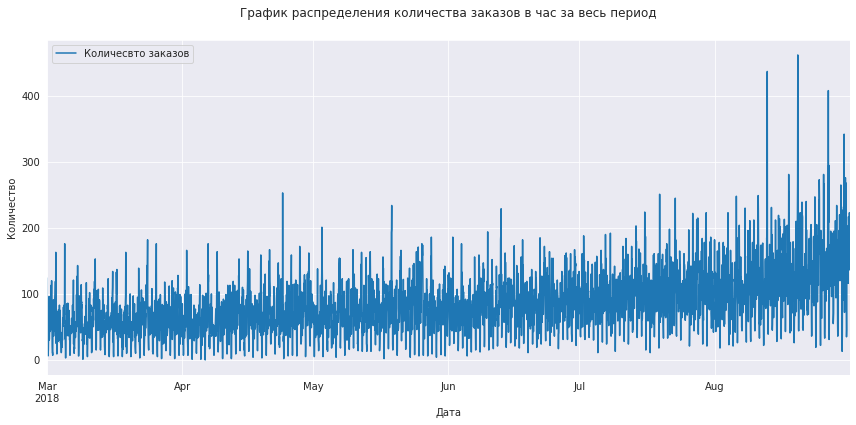

In [12]:
sns.set_style('darkgrid')
data_res.plot(ax=plt.gca(),figsize=(12,6))
plt.legend(['Количесвто заказов'])
plt.title('График распределения количества заказов в час за весь период', y=1.05)
plt.xlabel('Дата')
plt.ylabel('Количество')
plt.tight_layout()
plt.show()

##### На графике видно, что с марта 2018 года среднее количество заказов растёт. Постараемся определеть сезонность или тренд в количестве заказов

In [13]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [14]:
decomposed=seasonal_decompose(data_res)

<a id="step_2.1"></a>
## Определим тренд

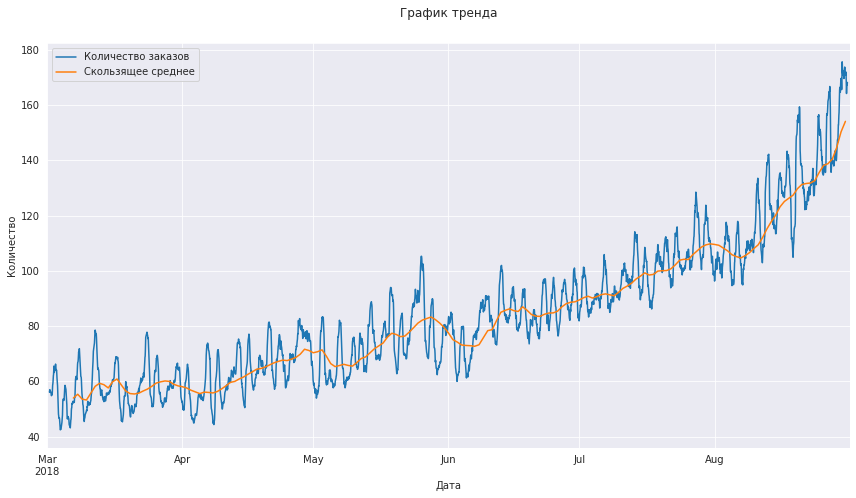

In [15]:
decomposed.trend.plot(ax=plt.gca(),figsize=(12,6))
decomposed.trend.resample('1D').mean().rolling(7).mean().plot(ax=plt.gca(),figsize=(12,7))
plt.legend(['Количество заказов', 'Скользящее среднее'])
plt.title('График тренда', y=1.05)
plt.xlabel('Дата')
plt.ylabel('Количество')
plt.tight_layout()

### Явно выраженный ежемесячный тренд роста количества заказов начиная с марта 2018 года . Определим стандартное отклонение за весь период времени

In [16]:
print('Стандартное отклонение: ',decomposed.trend.std())

Стандартное отклонение:  num_orders    26.311419
dtype: float64


<a id="step_2.2"></a>
## Определим сезонность

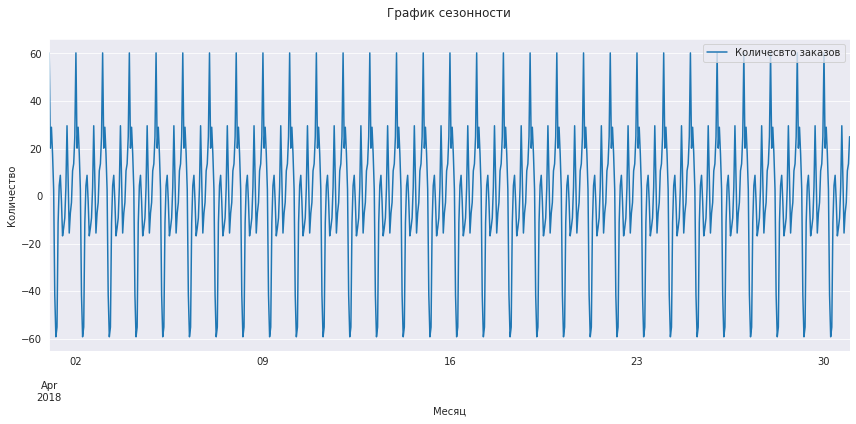

In [17]:
decomposed.seasonal['2018-04':'2018-04'].plot(ax=plt.gca(),figsize=(12,6))
plt.legend(['Количесвто заказов'])
plt.title('График сезонности', y=1.05)
plt.xlabel('Месяц')
plt.ylabel('Количество')
plt.tight_layout()

### Посчитаем стандартные отклонения двух отрезков времени:

In [18]:
print('Стандартное отклонение: ',decomposed.seasonal['2018-03':'2018-06'].std())
print('Среднее значение: ',decomposed.seasonal['2018-03':'2018-06'].mean().round(10))

Стандартное отклонение:  num_orders    26.158092
dtype: float64
Среднее значение:  num_orders    0.0
dtype: float64


In [19]:
print('Стандартное отклонение: ',decomposed.seasonal['2018-06':'2018-09'].std())
print('Среднее значение: ',decomposed.seasonal['2018-06':'2018-09'].mean().round(10))

Стандартное отклонение:  num_orders    26.159549
dtype: float64
Среднее значение:  num_orders    0.0
dtype: float64


##### На данном графике сезонности явно выраженный стационарный временной ряд, у которого среднее значение и стандартное отклонение не изменяются с течением времени. А ещё на этом графике видно, что количество заказов не завист от сезонности, возможно, у нас данные имеют слишком короткий срок для определения сезонных параметров. По этому уделим больше внимания тренду

<a id="step_2.3"></a>
### Остаток декомпозиции

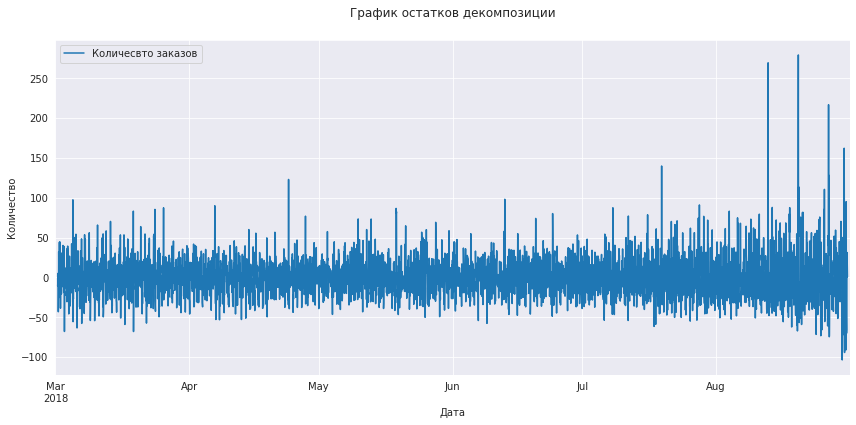

In [20]:
decomposed.resid.plot(ax=plt.gca(),figsize=(12,6))
plt.legend(['Количесвто заказов'])
plt.title('График остатков декомпозиции', y=1.05)
plt.xlabel('Дата')
plt.ylabel('Количество')
plt.tight_layout()

<a id="step_2.4"></a>
### Для более качествоенного предсказания моделей оценим распределение даных и отсортируем (шумные)выбивающиеся значения.

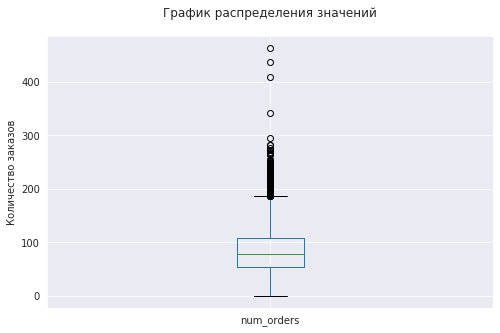

In [21]:
plt.figure(figsize=(8,5))
data_res.boxplot('num_orders')
plt.title('График распределения значений', y=1.05)
plt.ylabel('Количество заказов')
plt.show()

##### На графике видны выбивающиеся значения начиная с 200 заказов в час, но чтобы избежать уменьшения нашей выборки, выясним, что это за дни. Возьмём несколько таких дней до и после этого значения и рассчитаем медиану. Подставим вместо большого значения медиану,

In [22]:
data_res['dayofweek'] = data_res.index.dayofweek
data_res.query('num_orders > 300')['dayofweek'].value_counts()

0    8
5    3
3    3
6    2
4    2
2    1
1    1
Name: dayofweek, dtype: int64

##### Определили, что понедельников встречается 3 раза, а четверг всего 1 , создадим функцию для маркировки выбивающихся значений и зафиксируем их в отдельных столбцах

In [23]:
def additional_index(n_weekday1,trashold,idx):
    k=[]
    for i in data_res['dayofweek']:
        if i == n_weekday1:
            for u in data_res['num_orders']:
                if u >= trashold:
                    s_val= idx
            k.append(s_val)
        else:
            v=0
            k.append(v)

    return k

##### На вход функция принимает денеь недели, порог, и значение-идентификатор

In [24]:
data_res['value_diff_monday']= additional_index(0,300,1)

In [25]:
data_res['value_diff_thursday']= additional_index(3,300,2)

##### Проверяем результат 

In [26]:
data_res.query('num_orders > 300')

,num_orders,dayofweek,value_diff_monday,value_diff_thursday
datetime,,,,
2018-08-13 02:00:00,437,0,1,0
2018-08-20 02:00:00,462,0,1,0
2018-08-27 02:00:00,408,0,1,0
2018-08-30 17:00:00,342,3,0,2


#### Посмотрим на значения *понедельника* и найдём медиану

In [27]:
median_m=data_res.query('250 > num_orders < 450 and dayofweek == 0').median()
median_m[0]

81.0

##### Заполним медианным значением выбивающиеся значения по понедельнику

In [28]:
data_res.loc[(data_res.num_orders > 300) & (data_res.dayofweek == 0), 'num_orders'] = median_m[0]

#### Посмотрим на значения *четверга* и найдём медиану

In [29]:
median_t=data_res.query('250 > num_orders < 450 and dayofweek == 3').median()
median_t[0]

78.0

##### Заполним медианным значением выбивающиеся значения по четвергу

In [30]:
data_res.loc[(data_res.num_orders > 300) & (data_res.dayofweek == 3), 'num_orders'] = median_t[0]

<a id="step_2.end"></a>
## Вывод

Данные проанализированы, тренд известен, шумные значения исключены. Переидём к процессу обучения моделей и созданию дополнительных признаков, на основе которых наши модели будут обучаться и делать предсказания.

----

<a href='#start'>Вернуться к оглавлению</a>
<a id="step_3"></a>
# Обучение

## Создадим функцию для добавления в нашу выборку признаков и отстающего значения для удобства подбора параметров моделей

In [31]:
def make_features(data, max_lag, rolling_mean_size):
    #data['year'] = data.index.year
    data['month'] = data.index.month
    #data['day'] = data.index.day
    
    data['hour']= data.index.hour
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

##### Добавим 9 столбцов отстающего значения и один столбец скользящего среднего значения с окном в 5 часов

In [32]:
make_features(data_res, 9, 5)

##### Проверим результат

In [33]:
data_res.head()

,num_orders,dayofweek,value_diff_monday,value_diff_thursday,month,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,rolling_mean
datetime,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124.0,3,0,2,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85.0,3,0,2,3,1,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71.0,3,0,2,3,2,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66.0,3,0,2,3,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43.0,3,0,2,3,4,66.0,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN


<a id="step_3.1"></a>
## Определим тестовую и тренировочную выборку

In [34]:
train,test=train_test_split(data_res, shuffle=False, test_size=0.1)

##### Удалим отсутствующие значения из тренировочных данных, которые образовались в результате сдвига

In [35]:
train = train.dropna()

##### Отделим целевой признак от наших данных

In [36]:
train_features=train.drop('num_orders',axis=1)
train_target=train['num_orders']

In [37]:
test_features=test.drop('num_orders',axis=1)
test_target=test['num_orders']

##### Проверим результат

In [38]:
train_sample=train_features.shape[0]/data_res.shape[0]
test_sample=test_target.shape[0]/data_res.shape[0]

print('Размер тренировочной выборки- {:.0%}'.format(train_sample))
print('Размер тестовой выборки - {:.0%}'.format(test_sample))

Размер тренировочной выборки- 90%
Размер тестовой выборки - 10%


<a id="step_3.2"></a>
## Для расчёта целевой метрики используем RMSE и напишем функцию для её расчёта

In [39]:
def rmse(test,predict):
    return ((mean_squared_error(test,predict))**0.5).round(2)

<a id="step_3.3"></a>
## Создадим функцию, которая будет принимать на вход целевые и предсказанные значения, а возвращать абсолютное и среднеквадратичное отклонение на графиках с визуальным распределением разброса целевых признаков 

In [40]:
def illustration_target(test,predict):
    rmse= mean_squared_error(test,predict)
    mae=mean_absolute_error(test,predict)
    
   
    plt.figure(figsize=(8, 8))
    plt.plot(predict,test,'o', alpha=0.5)
    plt.text(225,80,'MAE={:.2f}'.format(mae))
    plt.text(225,73,'RMSE={:.2f}'.format(rmse**0.5))
    plt.xlim(20,300)
    plt.ylim(20,300)
    plt.plot([0,300],[0,300],'--y', linewidth=2)
    plt.title('График отношения предсказанных значений к истинным значениям', y=1.05)
    plt.xlabel('Предсказанные значения')
    plt.ylabel('Истинные значения')
    plt.show()

<a id="step_3.4"></a>
## Проверим предсказания модели `LinearRegression`

In [41]:
model_lr=LinearRegression(normalize=True)
model_lr.fit(train_features,train_target)
predict_lr=model_lr.predict(test_features)
predict_lr=predict_lr.round()
mae_lr=mean_absolute_error(test_target, predict_lr)
print('MAE модели Линейная Регрессия равна:',mae_lr.round(2))
rmse_lr=rmse(test_target, predict_lr)
print('RMSE модели Линейная Регрессия равна:', rmse_lr)

MAE модели Линейная Регрессия равна: 41.24
RMSE модели Линейная Регрессия равна: 52.56


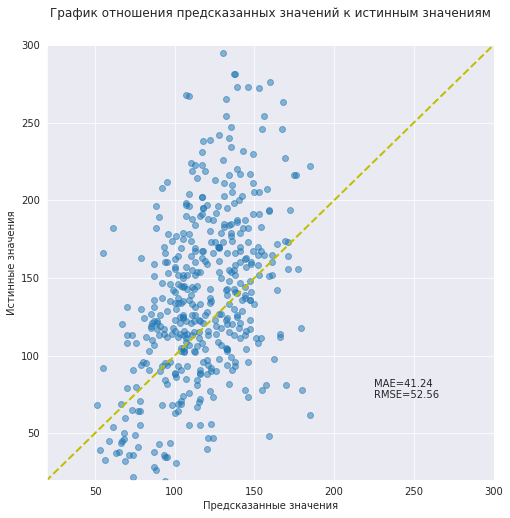

In [42]:
illustration_target(test_target, predict_lr)

<a id="step_3.5"></a>
## Проверим предсказания модели `RandomForestRegressor`

In [43]:
from sklearn.model_selection import TimeSeriesSplit

In [44]:
parametrs = { 'n_estimators': range (5, 18),
              'max_depth': range (9, 21)}
split_index = TimeSeriesSplit().split(train_features)
model_rf = RandomForestRegressor(random_state=12345)
grid_rf = GridSearchCV(model_rf, parametrs, cv=split_index, scoring=make_scorer(rmse, greater_is_better=False))
grid_rf.fit(train_features, train_target)

best_score_rf = -1*grid_rf.best_score_

parametrs_r_gs_d=pd.Series(grid_rf.best_params_)[0]
parametrs_r_gs_n=pd.Series(grid_rf.best_params_)[1]
print('Значение RMSE на обучающей выборке равно: {:.2f}'. format(best_score_rf), '\nМаксимальная глубина:',parametrs_r_gs_d, '\nКоличество деревьев:',parametrs_r_gs_n)

Значение RMSE на обучающей выборке равно: 27.24 
Максимальная глубина: 14 
Количество деревьев: 16


In [45]:
predict_rf=grid_rf.predict(test_features)
predict_rf=predict_rf.round()

In [46]:
rmse_rf=rmse(test_target, predict_rf)
print('RMSE модели Случайный лес равна:', rmse_rf)

RMSE модели Случайный лес равна: 41.24


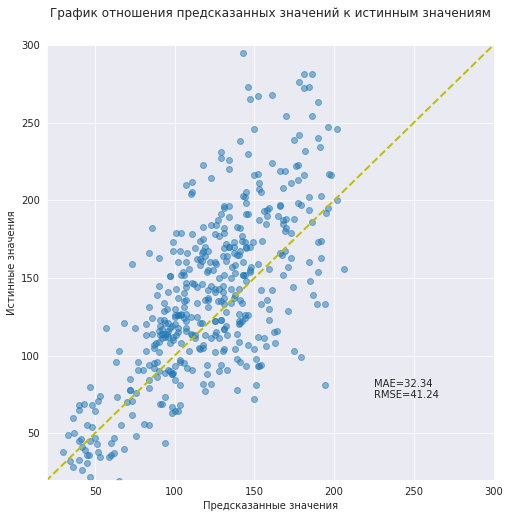

In [47]:
rmse_rf = rmse(test_target,predict_rf)
mae_rf=mean_absolute_error(test_target, predict_rf)
illustration_target(test_target, predict_rf)

<a id="step_3.6"></a>
## Проверим работу градиентного спуска при помощи `CatBoostRegressor`

In [48]:
model_cat = CatBoostRegressor(random_state=123,learning_rate=0.4, verbose=100,n_estimators=300)
model_cat.fit(train_features, train_target, eval_set=(test_features,test_target))
predict_cat=model_cat.predict(test_features)
predict_cat=predict_cat.round()

0:	learn: 31.8277140	test: 69.6289170	best: 69.6289170 (0)	total: 50ms	remaining: 14.9s
100:	learn: 14.0133974	test: 43.5197774	best: 43.2699979 (74)	total: 2.23s	remaining: 4.39s
200:	learn: 9.9832746	test: 42.7934685	best: 42.4311619 (166)	total: 4.29s	remaining: 2.11s
299:	learn: 7.6235143	test: 42.3680861	best: 42.3600754 (298)	total: 6.52s	remaining: 0us

bestTest = 42.36007537
bestIteration = 298

Shrink model to first 299 iterations.


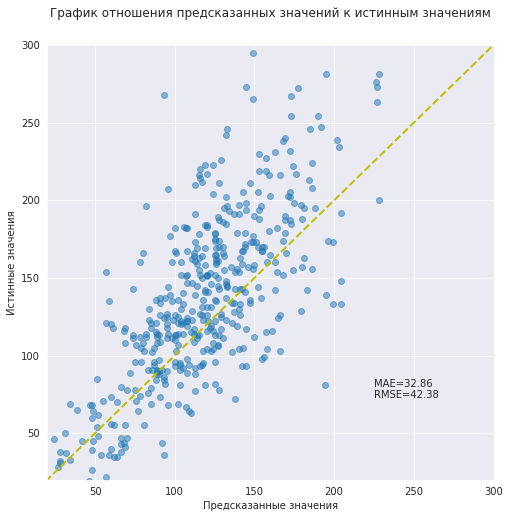

In [49]:
rmse_cat=rmse(test_target, predict_cat)
mae_cat=mean_absolute_error(test_target, predict_cat).round(2)
illustration_target(test_target, predict_cat)

<a id="step_3.end"></a>
## Вывод

Для того, чтобы обучить модели и добиться удовлетворяющего нас качества предсказания, мы добавили в наши данные признаки по дате события включая месяц, день недели, дату и час, так же 9 столбцов со сдвигом целевой метки и скользящее среднее значение с окном в 5 часов. По графикам распределения можно заметить, что все модели справились со своей задачей не плохо, однако модели `RandomForestRegressor` и `CatBoostRegressor` показали практически равный результат, с незначительным отклонением.

----

<a href='#start'>Вернуться к оглавлению</a>
<a id="step_4"></a>
# Анализ работы моделей на тестовых данных

<b>Для наглядности сведём $RMSE$ и $MAE$ в таблицу

In [50]:
column=['RMSE модели','MAE модели']

comparison_tabl = pd.DataFrame(index=['RMSE модели','MAE модели',], columns=['LinearRegression','RandomForestRegressor','CatBoostRegressor'])
comparison_tabl['LinearRegression'] = rmse_lr, mae_lr
comparison_tabl['RandomForestRegressor'] = rmse_rf, mae_rf
comparison_tabl['CatBoostRegressor'] = rmse_cat,mae_cat

comparison_tabl.T.style.highlight_min(color='yellowgreen',subset=column).highlight_null(null_color='lightgrey').highlight_max(color='coral',subset=column)

,RMSE модели,MAE модели
LinearRegression,52.56,41.2398
RandomForestRegressor,41.24,32.3394
CatBoostRegressor,42.38,32.86


##### На удивление обе модели `RandomForestRegressor` и `CatBoostRegressor` показали практически равный результат при этом <br><br> всё же  модель `CatBoostRegressor` на метрике $RMSE$ оказалась чуть лучшей

<a id="step_4.1"></a>
## Проведём анализ остатков по предсказаниям моделей

In [51]:
test_featuresy=test_features.copy()
test_featuresy['Test_LinRegressor']=predict_lr-test_target
test_featuresy['Test_RandomForest']=predict_rf-test_target
test_featuresy['Test_CAT']=predict_cat-test_target
test_featuresy.head()

,dayofweek,value_diff_monday,value_diff_thursday,month,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,rolling_mean,Test_LinRegressor,Test_RandomForest,Test_CAT
datetime,,,,,,,,,,,,,,,,,,
2018-08-13 14:00:00,0,1,0,8,14,119.0,92.0,144.0,156.0,137.0,91.0,39.0,66.0,83.0,129.6,4.0,-12.0,-16.0
2018-08-13 15:00:00,0,1,0,8,15,102.0,119.0,92.0,144.0,156.0,137.0,91.0,39.0,66.0,122.6,-70.0,-57.0,-50.0
2018-08-13 16:00:00,0,1,0,8,16,175.0,102.0,119.0,92.0,144.0,156.0,137.0,91.0,39.0,126.4,0.0,30.0,8.0
2018-08-13 17:00:00,0,1,0,8,17,144.0,175.0,102.0,119.0,92.0,144.0,156.0,137.0,91.0,126.4,-14.0,-9.0,-36.0
2018-08-13 18:00:00,0,1,0,8,18,152.0,144.0,175.0,102.0,119.0,92.0,144.0,156.0,137.0,138.4,29.0,12.0,16.0


<a id="step_4.2"></a>
## Составим сводную таблицу по среднему значению отклонения предсказанных от истинных значений с разбивкой на дни недели

In [52]:
analis_table=test_featuresy.groupby('dayofweek')[['Test_LinRegressor','Test_RandomForest','Test_CAT']].mean()
analis_table.columns=['LinearRegressor','RandomForestRegressor','CatBoostRegressor']
analis_table.sort_index(ascending=True)

,LinearRegressor,RandomForestRegressor,CatBoostRegressor
dayofweek,,,
0,-19.189655,-17.396552,-18.327586
1,-17.819444,-11.527778,-14.347222
2,-19.125000,-16.027778,-18.277778
3,-21.625000,-17.361111,-25.000000
4,-26.222222,-21.333333,-25.819444
5,-18.375000,-15.208333,-14.395833
6,-12.791667,-12.729167,-12.937500


<a id="step_4.3"></a>
### Для наглядности отобразим отклонения на графике

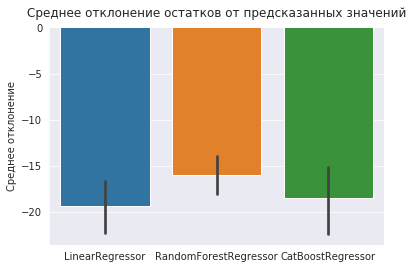

In [53]:
sns.barplot(data=analis_table)

plt.title('Среднее отклонение остатков от предсказанных значений', y=1.02)
plt.ylabel('Среднее отклонение')
plt.show()

#### Разобъём на дни недели

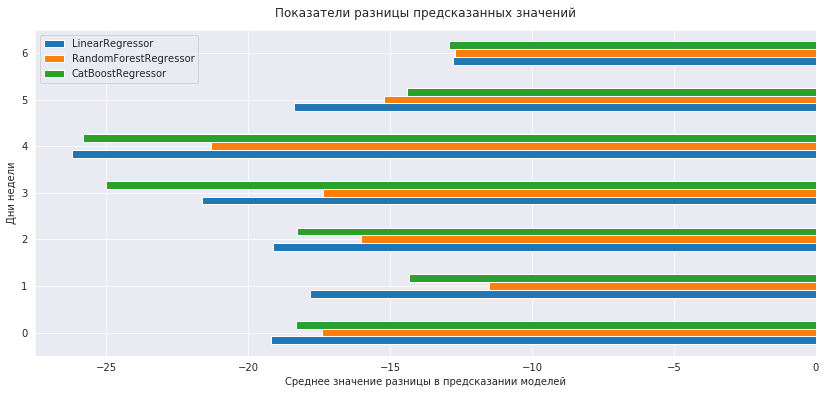

In [54]:
analis_table.sort_index(ascending=True).plot(kind='barh',align='center',figsize=(14,6))
plt.title('Показатели разницы предсказанных значений', y=1.02)
plt.xlabel('Среднее значение разницы в предсказании моделей')
plt.ylabel('Дни недели')
plt.show()

#### Выведем на график значения остатков предсказания наилучшей модели `RandomForestRegressor`

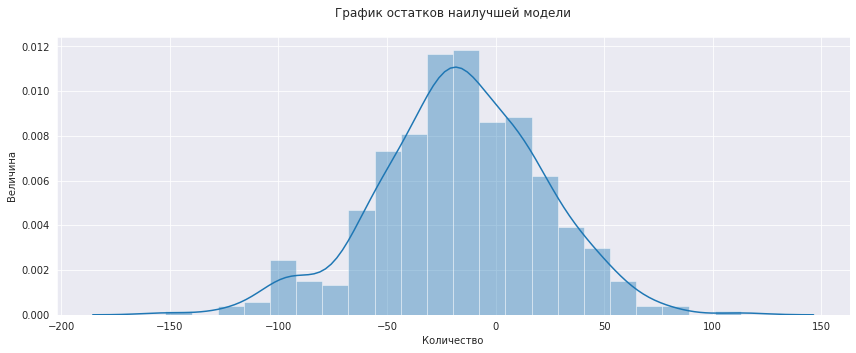

In [55]:
plt.figure(figsize=(12,5))
sns_plot = sns.distplot(test_featuresy['Test_RandomForest'])
fig = sns_plot.get_figure()
plt.title('График остатков наилучшей модели', y=1.05)
plt.xlabel('Количество')
plt.ylabel('Величина')
plt.tight_layout()

##### Таким образом мы обнаружили, что все наши модели ошибаются в меньшую сторону, больше всех ошибается модель <br> <br>`LinRegressor `, в то время как модель `RandomForestRegressor`  c незначительным отрывом от `CatBoostRegressor` показала себя <br> <br> лучше других

<a id="step_4.4"></a>
## Проверим предсказания нашей наилучшей модели 

In [56]:
#predict_cat=model_cat.predict(test_features)
#predict_rf=predict_cat.round()

model_r = RandomForestRegressor(random_state=12345, n_estimators=16, max_depth=14)
model_r.fit(train_features, train_target)
predict_rf = model_r.predict(test_features)
rmse_rf=rmse(test_target, predict_rf.round())
print('RMSE модели Случайный лес равна:', rmse_rf)

RMSE модели Случайный лес равна: 41.24


##### <font color='green'>Целевая метка достигнута! На тестовых данных наша нилучшая модель по метрике $RMSE$ даёт наименьшее значение в *41.24*!

<a id="step_4.5"></a>
## Посмотрим значения предсказания наилучшей модели на графиках и сравним с целевыми

##### Преобразуем предсказания в серию с присвоением индексов времени

In [57]:
pred_data= pd.Series(predict_rf, index=test_features.index)
pred_data.head()

datetime
2018-08-13 14:00:00     90.459676
2018-08-13 15:00:00    117.640789
2018-08-13 16:00:00    173.937500
2018-08-13 17:00:00    143.203472
2018-08-13 18:00:00    116.000000
Freq: H, dtype: float64

<a id="step_4.6"></a>
### Построим график за целевой период времени и нанесём на него скользящие средние значения

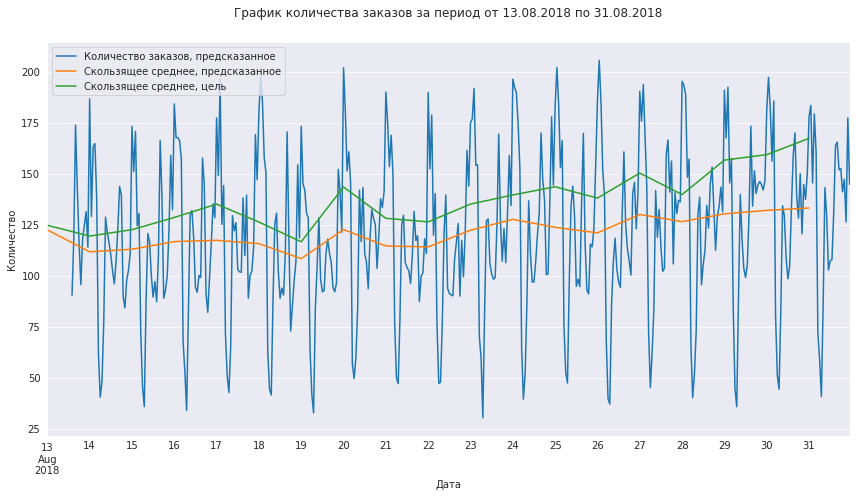

In [58]:
pred_data.plot(ax=plt.gca(),figsize=(12,7))
pred_data.resample('1D').mean().rolling(1).mean().plot(ax=plt.gca(),figsize=(12,7))
test_target.resample('1D').mean().rolling(1).mean().plot(ax=plt.gca(),figsize=(12,7))
plt.legend(['Количество заказов, предсказанное', 'Скользящее среднее, предсказанное', 'Скользящее среднее, цель'])
plt.title('График количества заказов за период от 13.08.2018 по 31.08.2018', y=1.05)
plt.xlabel('Дата')
plt.ylabel('Количество')
plt.tight_layout()

<a id="step_4.7"></a>
### График цикличный и повторяется ежедневно, возьмём период по дням недели

##### Для наглядности внесём в наши данные нименования дней недели

In [59]:
pred_data=pred_data.to_frame()
pred_data.columns=['Количество заказов']
pred_data['Количество заказов']=pred_data['Количество заказов'].round().astype('int')
pred_data['dayofweek']=pred_data.index.day_name()
pred_data.head()

,Количество заказов,dayofweek
datetime,,
2018-08-13 14:00:00,90,Monday
2018-08-13 15:00:00,118,Monday
2018-08-13 16:00:00,174,Monday
2018-08-13 17:00:00,143,Monday
2018-08-13 18:00:00,116,Monday


##### Выполним ту же операцию с тестовой выборкой

In [60]:
test_t=test_target.to_frame()
test_t.columns=['Количество заказов']
test_t['dayofweek']=test_target.index.day_name()

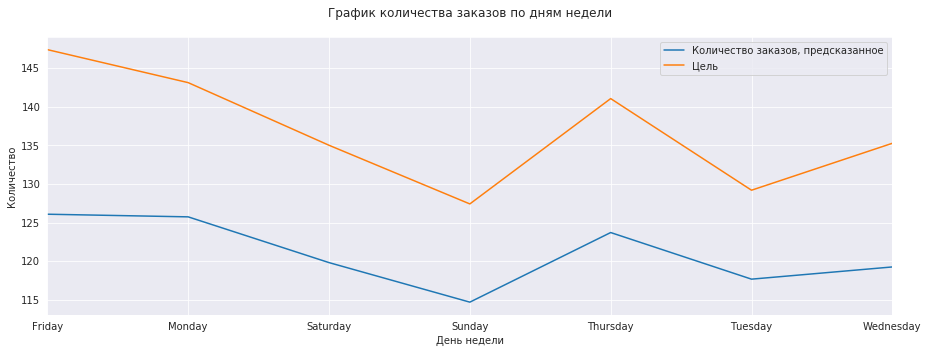

In [61]:
pred_data.pivot_table(index='dayofweek', values='Количество заказов').plot(ax=plt.gca(),figsize=(13,5))
test_t.pivot_table(index='dayofweek', values='Количество заказов').plot(ax=plt.gca(),figsize=(13,5))
plt.legend(['Количество заказов, предсказанное','Цель'])
plt.title('График количества заказов по дням недели', y=1.05)
plt.xlabel('День недели')
plt.ylabel('Количество')
plt.tight_layout()

##### На графике отчётливо видно, что среднее количество заказов такси в день меняется в зависимости от дня недели, такая потребность в такси повторяется еженедельно. Для планирования на ежедневной основе, можно прибегнуть к ручной корректровке и добавить к предсказанным значениям (в зависимости от дня недели) разницу в предсказании, чтобы приблизить прогноз к целевым данным. В нашем случае целью состоит предсказать спрос на следующий час, что более тонко и такой подход нам может навредить. Для понимания работы нашей модели по часам сверим эти значения на графике с целевыми

<a id="step_4.8"></a>
### Посмотрим на  временной период одного дня с распределением по часам и на предсказания нашей лучшей модели `RandomForestRegressor`

In [62]:
day1='2018-08-15 00:00:00'
day2='2018-08-15 23:00:00'

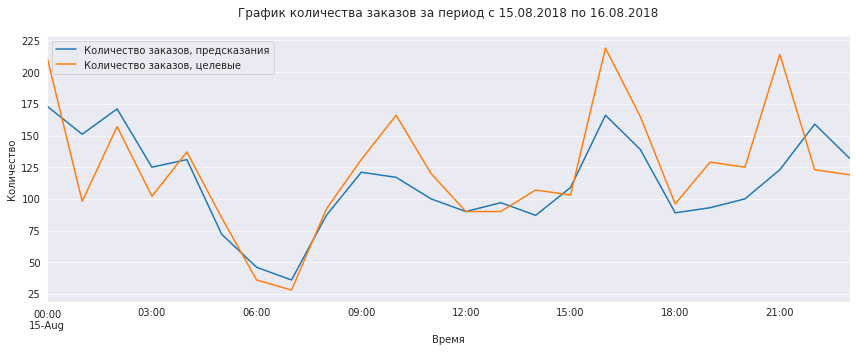

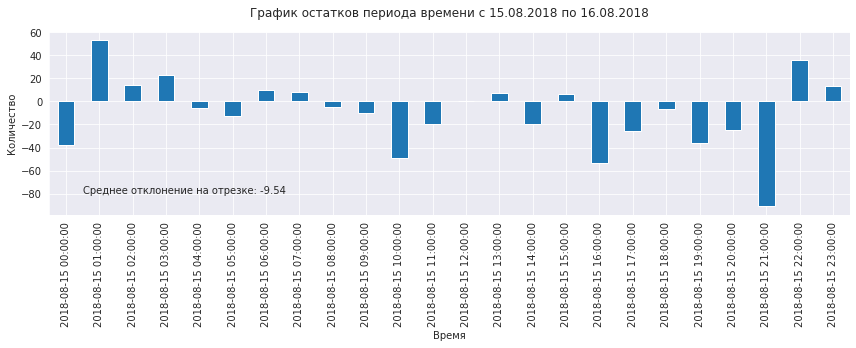

In [63]:
pred_data[day1:day2].plot(ax=plt.gca(),figsize=(12,5))
test_target[day1:day2].plot(ax=plt.gca(),figsize=(12,5))

plt.legend(['Количество заказов, предсказания', 'Количество заказов, целевые'])
plt.title('График количества заказов за период c 15.08.2018 по 16.08.2018', y=1.05)
plt.xlabel('Время')
plt.ylabel('Количество')
plt.tight_layout()
plt.subplots()

test_featuresy[day1:day2]['Test_RandomForest'].plot(kind='bar',ax=plt.gca(),figsize=(12,5))
plt.title('График остатков периода времени c 15.08.2018 по 16.08.2018', y=1.05)
plt.text(0.5,-80,'Среднее отклонение на отрезке: {:.2f}'.format(test_featuresy[day1:day2]['Test_RandomForest'].mean()))
plt.xlabel('Время')
plt.ylabel('Количество')
plt.tight_layout()

<a id="step_4.end"></a>
## Вывод

Отлично! Наша модель хорошо справляется с задачей предсказывать количество заказов с разбивкой по часам. На часовом графике это хорошо видно, к тому же можем наблюдать спад потребления в часы с 4 до 7 утра и пиковые значения под вечер. Судя по графикам такая статистика имеет ежедневный характер, что позволяет планировать закрузку и график работы таксопарка.

----


<a href='#start'>Вернуться к оглавлению</a>
<a id="step_5.end"></a>
# Общий вывод

   Перед нами стояла задача, на исторических данных о заказах такси в аэропортах построить модель, которая смогла бы прогнозировать количество заказов такси на следующий час, при этом значенние метрики $RMSE$ не должно быть больше $48$<br>
   
   В нашем распоряжении были данные только количества заказов с привязкой к дате и времени. Для того, чтобы обучить модели и добиться удовлетворяющего нас качества предсказания, мы добавили в наши данные признаки по дате события включая год, день недели, дату и час, так же 9 столбцов со сдвигом целевой метки и скользящее среднее значение с окном в $5$ часов. <br>
   
   Для нахождения наилучшего значения по заданной метрике мы протестировали несколько моделей `LinearRegressor`, `RandomForestRegressor` и `CatBoostRegressor` c подбором разных гиперпараметров.<br>
   
   В результате обе модели `RandomForestRegressor` и `CatBoostRegressor` нашли приблизительно одинаковое наименьшее значение метрики $RMSE$ равное $41.24$ и $42.38$ соответственно.<br>
   
   Таким образом мы достигли пороговое значение метрики $RMSE$ в $48$ единиц и для компании *Чётенькое такси* можем смело рекомендовать, для предсказания количества заказов такси на следующий час, модель `RandomForestRegressor`

----